In [1]:
import pandas as pd
import re
import numpy as np
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11508,https://www.airbnb.com/rooms/11508,20220922013624,2022-09-22,city scrape,Amazing Luxurious Apt-Palermo Soho,<b>The space</b><br />LUXURIOUS NEW APT: 1 BDR...,AREA: PALERMO SOHO<br /><br />Minutes walking ...,https://a0.muscache.com/pictures/19357696/b1de...,42762,...,4.97,4.93,4.93,NaN,f,1,1,0,0,0.24
1,118877,https://www.airbnb.com/rooms/118877,20220922013624,2022-09-22,city scrape,Entire Studio/apt in Buenos Aires,<b>The space</b><br />Inspired by the cultural...,NaN,https://a0.muscache.com/pictures/777724/21a535...,600320,...,4.86,4.45,4.64,NaN,t,2,2,0,0,0.18
2,14222,https://www.airbnb.com/rooms/14222,20220922013624,2022-09-22,city scrape,"RELAX IN HAPPY HOUSE - PALERMO, BUENOS AIRES",Beautiful cozy apartment in excellent location...,Palermo is such a perfect place to explore the...,https://a0.muscache.com/pictures/4695637/bbae8...,87710233,...,4.89,4.88,4.73,NaN,f,3,2,1,0,0.79
3,120874,https://www.airbnb.com/rooms/120874,20220922013624,2022-09-22,city scrape,Great apt 1 Bedroom - 1.5 Bath /Recoleta,<b>The space</b><br />This great apartment is ...,NaN,https://a0.muscache.com/pictures/108877484/5f3...,530261,...,4.80,4.80,4.50,NaN,f,27,26,0,0,0.07
4,122907,https://www.airbnb.com/rooms/122907,20220922013624,2022-09-22,city scrape,Spotless entire apt. Ideal location,Apartment is situated on 4th floor. There are ...,Boedo area is knowen for it's tango places. Th...,https://a0.muscache.com/pictures/12160576/0b27...,426566,...,4.86,4.82,4.57,NaN,t,8,8,0,0,0.21


In [3]:
len(df.columns)

75

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17947 entries, 0 to 17946
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17947 non-null  int64  
 1   listing_url                                   17947 non-null  object 
 2   scrape_id                                     17947 non-null  int64  
 3   last_scraped                                  17947 non-null  object 
 4   source                                        17947 non-null  object 
 5   name                                          17944 non-null  object 
 6   description                                   17435 non-null  object 
 7   neighborhood_overview                         10426 non-null  object 
 8   picture_url                                   17947 non-null  object 
 9   host_id                                       17947 non-null 

Checking if there are duplicates records

In [5]:
df.duplicated().sum()

0

In [6]:
df['id'].duplicated().sum()

0

Checking the null values

In [7]:
df.isnull().sum().sort_values(ascending=False)[:30]

neighbourhood_group_cleansed    17947
bathrooms                       17947
calendar_updated                17947
license                         17584
neighbourhood                    7521
neighborhood_overview            7521
host_about                       7303
host_neighbourhood               4520
review_scores_accuracy           3920
review_scores_cleanliness        3920
review_scores_checkin            3919
review_scores_communication      3919
review_scores_location           3919
review_scores_value              3919
review_scores_rating             3807
last_review                      3807
first_review                     3807
reviews_per_month                3807
host_location                    3551
bedrooms                         2516
host_response_rate               2420
host_response_time               2420
host_acceptance_rate             2013
description                       512
beds                              245
bathrooms_text                     47
name        

# Data Cleaning

## Change df columns to the correct data type

### Date

In [8]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

df[['host_since', 'first_review', 'last_review']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17947 entries, 0 to 17946
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   host_since    17947 non-null  datetime64[ns]
 1   first_review  14140 non-null  datetime64[ns]
 2   last_review   14140 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 420.8 KB


### Numeric

In [9]:
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%','').astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).str.replace('%','').astype(float)

In [10]:
df['price'] = df['price'].str.replace('$','').str.replace(',', '').astype(float)

In [11]:
replace_data = { "bath": '',
                 "baths": '',
                 "shared": '',
                 "Shared": '',
                 "private": '',
                 "Private": '',
                 "Half-": '',
                 "half-": '',
                 "s": '',
                "": np.nan}

df['bathrooms_text'] = df['bathrooms_text'].replace(replace_data,regex=True)
df['bathrooms_text'] = pd.to_numeric(df['bathrooms_text'], errors='coerce')
df[['bathrooms_text', 'host_response_rate', 'host_acceptance_rate','price']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17947 entries, 0 to 17946
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms_text        17882 non-null  float64
 1   host_response_rate    15527 non-null  float64
 2   host_acceptance_rate  15934 non-null  float64
 3   price                 17947 non-null  float64
dtypes: float64(4)
memory usage: 561.0 KB


### Boolean

In [12]:
def string_to_boolean(series):
  series = series.map({'t': True, 'f': False})
  return series

In [13]:
df['host_is_superhost'] = string_to_boolean(df['host_is_superhost'])
df['host_has_profile_pic'] = string_to_boolean(df['host_has_profile_pic'])
df['host_identity_verified'] = string_to_boolean(df['host_identity_verified'])
df['instant_bookable'] = string_to_boolean(df['instant_bookable'])

df[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17947 entries, 0 to 17946
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   host_is_superhost       17947 non-null  bool 
 1   host_has_profile_pic    17947 non-null  bool 
 2   host_identity_verified  17947 non-null  bool 
 3   instant_bookable        17947 non-null  bool 
dtypes: bool(4)
memory usage: 70.2 KB


## Removing the HTML codification in the description field

In [14]:
df['description'] = df['description'].str.replace('<br />', ' ').str.replace('<b>','').str.replace('</b>', '')
df['description'][0]

'The space LUXURIOUS NEW APT: 1 BDRM- POOL/ GYM/ SPA/ 24-HR SECURITY  Palermo Soho, Buenos Aires  BUILDING DETAILS  Luxury building in the heart of the trendy Palermo Soho 24-hour security  Outdoor pool  FREE Gym and Spa in building (top floor with panoramic view) Lounge/common area for parties and guests with outdoor deck (top floor with panoramic view) Laundry in building  Restaurant on building grounds  Optional house keeping and room service   AREA: PALERMO SOHO  Minutes walking distance from most popular bars, restaurants and boutiques Buenos Aires Eco-Park within walking distance Botanical Garden and magnificent park with lake (“Bosques de Palermo”) within walking distance One block from Santa Fe Avenue and “D Line” subway  All major bus lines within walking distance  APARTMENT DETAILS  Fully Furnished 1 bedroom apartment  Wifi and Cable TV<'

## Feature engineering

In [15]:
# Number of characters from the listings name
df['len_name'] = df['name'].str.len()

In [16]:
# Number of characters from the listings name
df['len_description'] = df['description'].str.len()

In [17]:
# The host is in Argentina or not
df['host_in_argentina'] = np.where(df['host_location'].str.contains('Argentina'), True, False)

In [18]:
# If the minimum number of nights is greater than 30, they consider it a long-term rental,
# otherwise it is a short-term rental
df['rental_type'] = df['minimum_nights'].apply(lambda x: 'short-term' if x < 30 else 'long-term')

In [19]:
# To calculate the number of nights that were booked this last 12 months,
# I multiply the number of reviews by the minimum number of nights from the listing.
df['nights_booked_ltm'] = df['number_of_reviews_ltm'] * df['minimum_nights']

In [20]:
# Received income in the last 12 months
df['income_ltm'] = df['nights_booked_ltm'] * df['price']

In [21]:
# Does the host have one or more listings?
listings_by_host = df.groupby('host_id')[['id']].count()
listings_by_host['host_type'] = listings_by_host['id'].apply(lambda x: 'multi-listing' if x > 1 else 'single-listing')
listings_by_host.reset_index(inplace=True)
listings_by_host = listings_by_host.drop(['id'], axis=1)
listings_by_host

df = pd.merge(df, listings_by_host, how='left', on='host_id')

# EDA

In [22]:
hosts = df[['host_id', 'host_name', 'host_since','host_in_argentina', 'host_location', 'host_response_time',
            'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_total_listings_count',
            'host_has_profile_pic', 'host_identity_verified', 'host_type']]
hosts = hosts.drop_duplicates()
hosts['host_id'].duplicated().sum()

0

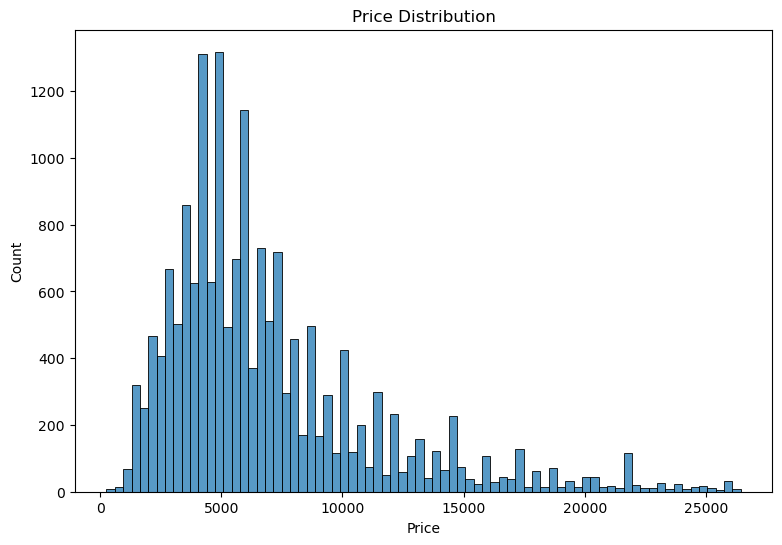

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))
q97 = df.loc[:, 'price'].quantile(0.97)
data = df[df['price'] < q97]
ax.set_title('Price Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Price')
sns.histplot(data=data, x='price', ax=ax)
plt.show()

In [24]:
df[['host_response_rate', 'host_acceptance_rate', 'host_total_listings_count',
    'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
    'reviews_per_month']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,host_response_rate,host_acceptance_rate,host_total_listings_count,price,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month
count,15527.00,15934.00,17947.00,17947.00,17947.00,17947.00,17947.00,14140.00
mean,91.33,79.73,21.58,11307.99,7.68,592.21,20.99,1.08
std,23.23,30.03,77.51,154991.57,27.97,895.01,37.82,1.17
min,0.00,0.00,1.00,260.00,1.00,1.00,0.00,0.01
25%,99.00,73.00,1.00,4136.00,2.00,90.00,1.00,0.25
50%,100.00,95.00,3.00,5790.00,3.00,365.00,6.00,0.69
75%,100.00,100.00,13.00,8685.00,5.00,1125.00,24.00,1.49
max,100.00,100.00,2365.00,14330511.00,1000.00,99999.00,577.00,12.58


## Host with 2365 listings

In [25]:
hosts.loc[hosts['host_total_listings_count'] == 2365]

,host_id,host_name,host_since,host_in_argentina,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,host_type
13090,258154594,Atanas,2019-04-26,False,"London, United Kingdom",within an hour,90.0,69.0,False,2365,True,True,multi-listing


## Host growth over the years

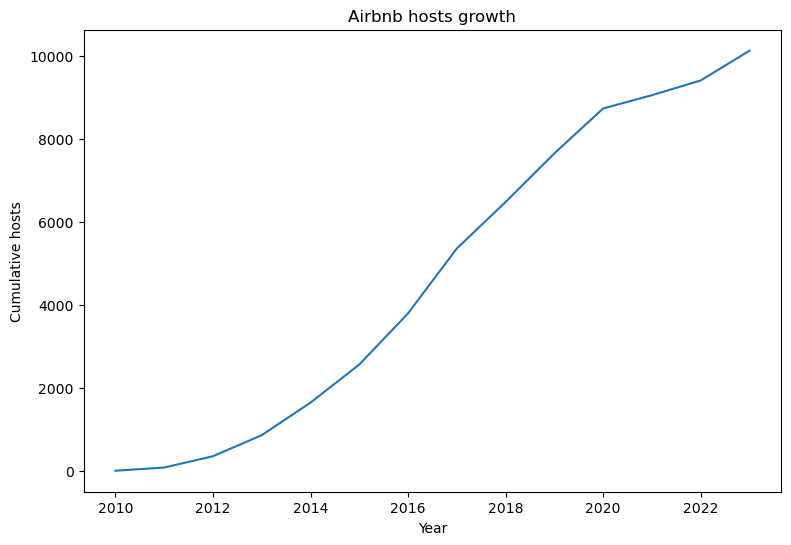

In [26]:
df_host = hosts[['host_id', 'host_since']]
df_host = df_host.set_index('host_since').resample('Y')
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.set_title("Airbnb hosts growth")
ax.set_ylabel('Cumulative hosts')
ax.set_xlabel('Year')
sns.lineplot(data=np.cumsum(df_host['host_id'].count()), ax=ax)
plt.show()

In [27]:
print(f"Total users: {np.sum(df_host['host_id'].count())}")

Total users: 10127


## Where the hosts are located?

In [28]:
(df['host_in_argentina'].value_counts()/len(df))*100

True     92.923608
False     7.076392
Name: host_in_argentina, dtype: float64

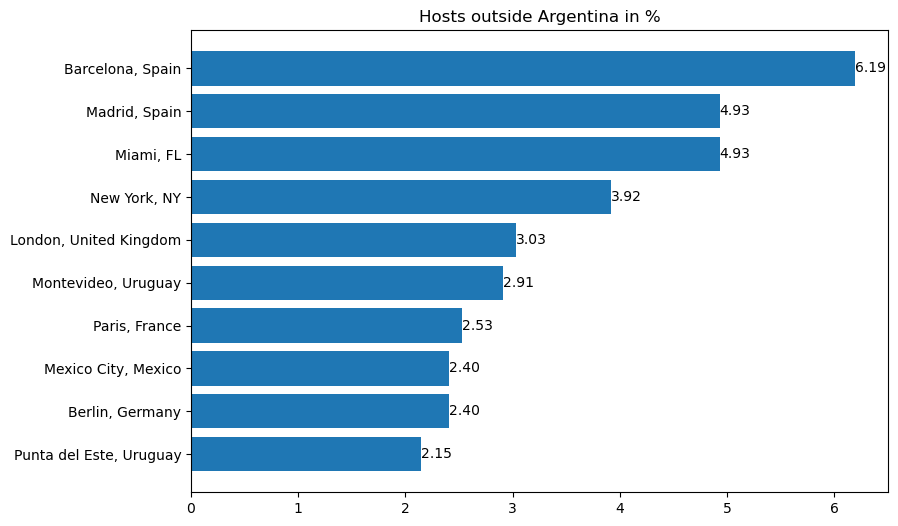

In [29]:
#Hosts outside Argentina
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
data = (hosts[hosts['host_in_argentina']==False]['host_location'].value_counts(normalize=True)*100).sort_values(ascending=False)[:10]
hbars = plt.barh(data.index,data.values)
plt.title('Hosts outside Argentina in %')
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
plt.show()

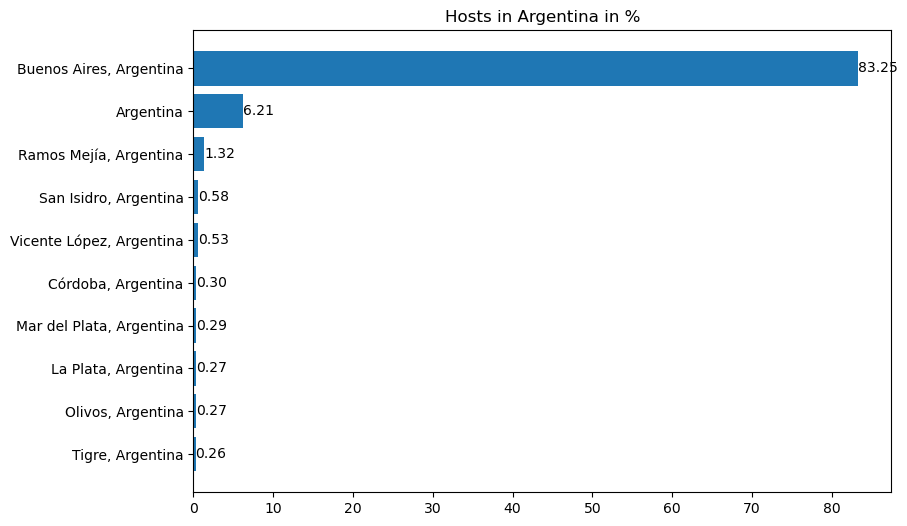

In [30]:
#Hosts in Argentina
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
data = (hosts[hosts['host_in_argentina']==True]['host_location'].value_counts(normalize=True)*100).sort_values(ascending=False)[:10]
hbars = ax.barh(data.index,data.values)
plt.title('Hosts in Argentina in %')
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
plt.show()

## Hosts

In [31]:
data = (df['host_is_superhost'].value_counts(normalize=True)*100).sort_values(ascending=False)
data

False    73.722628
True     26.277372
Name: host_is_superhost, dtype: float64

<AxesSubplot:xlabel='host_is_superhost', ylabel='price'>

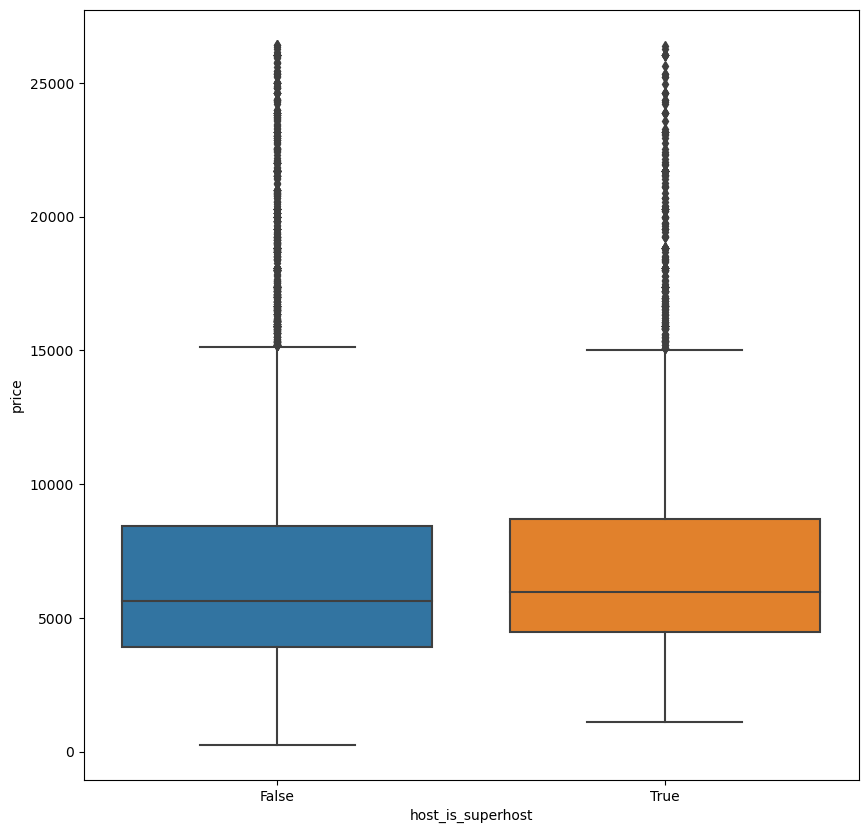

In [32]:
q97 = df.loc[:, 'price'].quantile(0.97)
data = df[df['price'] < q97]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=data, y='price', x='host_is_superhost')

<AxesSubplot:xlabel='host_is_superhost', ylabel='review_scores_rating'>

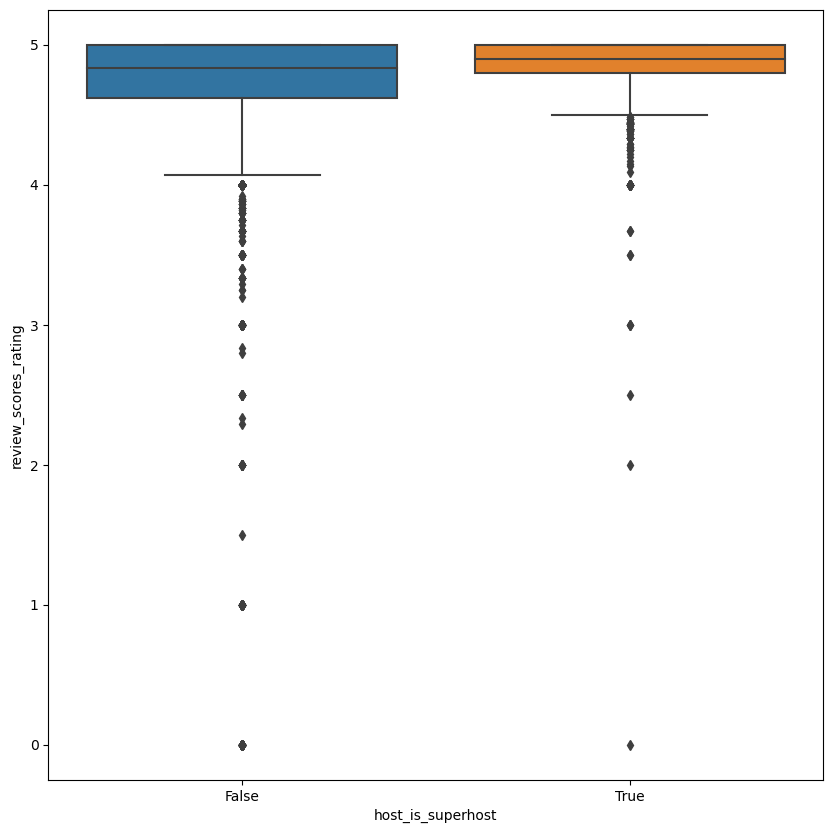

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=df, y='review_scores_rating', x='host_is_superhost')

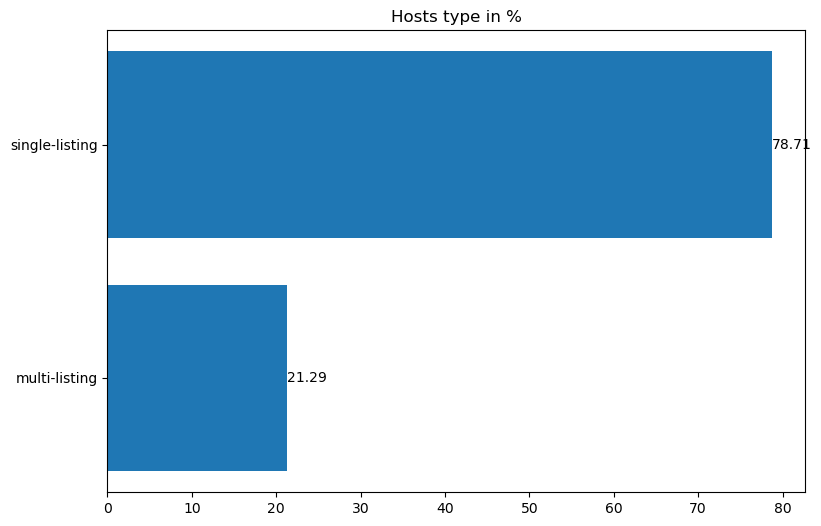

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
data = (hosts['host_type'].value_counts(normalize=True)*100).sort_values(ascending=False)
hbars = plt.barh(data.index,data.values)
plt.title('Hosts type in %')
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
plt.show()

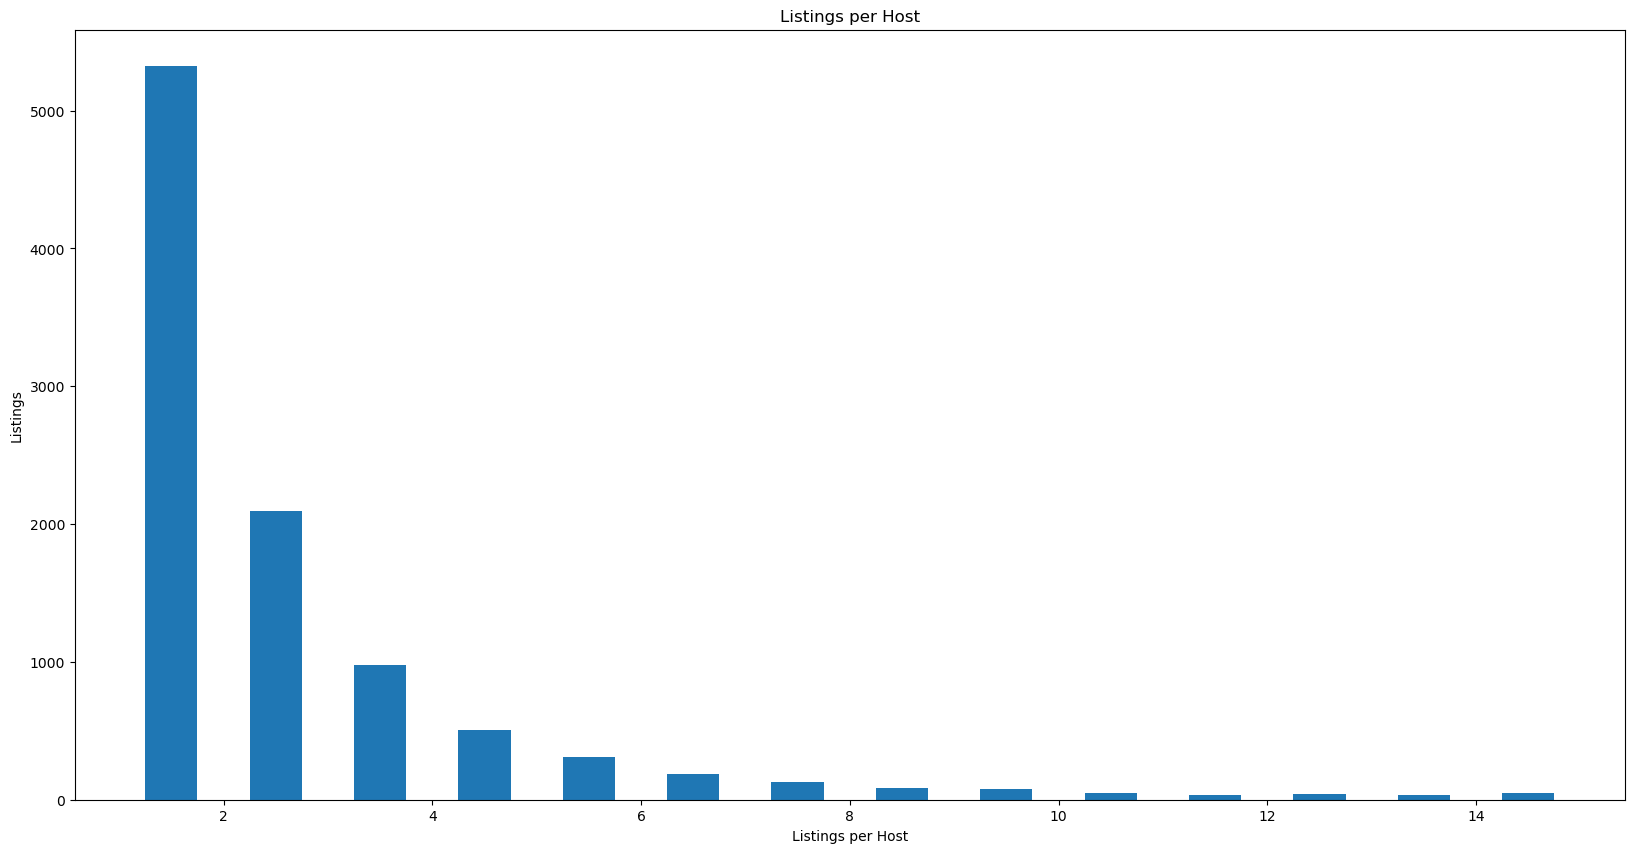

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bins = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.hist(data=hosts, x='host_total_listings_count', bins=bins, rwidth=0.5)
ax.set_ylabel('Listings')
ax.set_xlabel('Listings per Host')
plt.title('Listings per Host')
plt.show()

## Types of listings

In [36]:
df['room_type'].value_counts()

Entire home/apt    15603
Private room        2030
Shared room          194
Hotel room           120
Name: room_type, dtype: int64

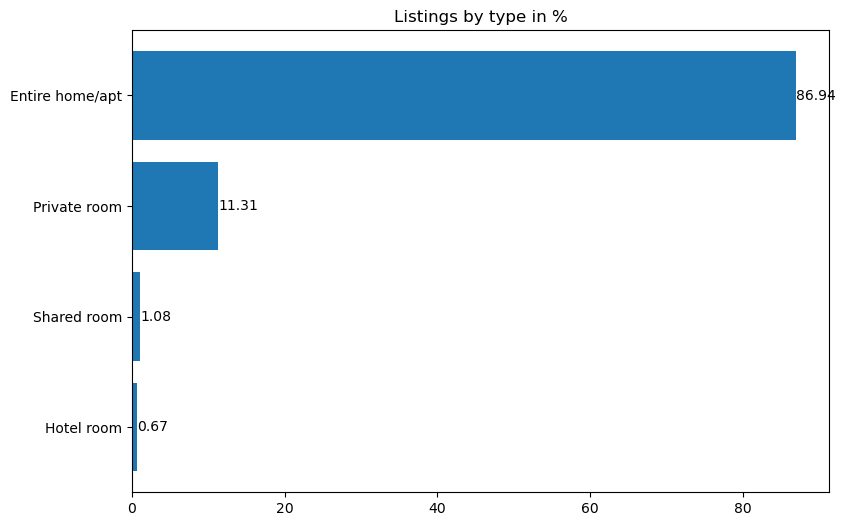

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
data = (df['room_type'].value_counts(normalize=True)*100).sort_values(ascending=False)
hbars = ax.barh(data.index,data.values)
plt.title('Listings by type in %')
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
plt.show()

<AxesSubplot:xlabel='room_type', ylabel='price'>

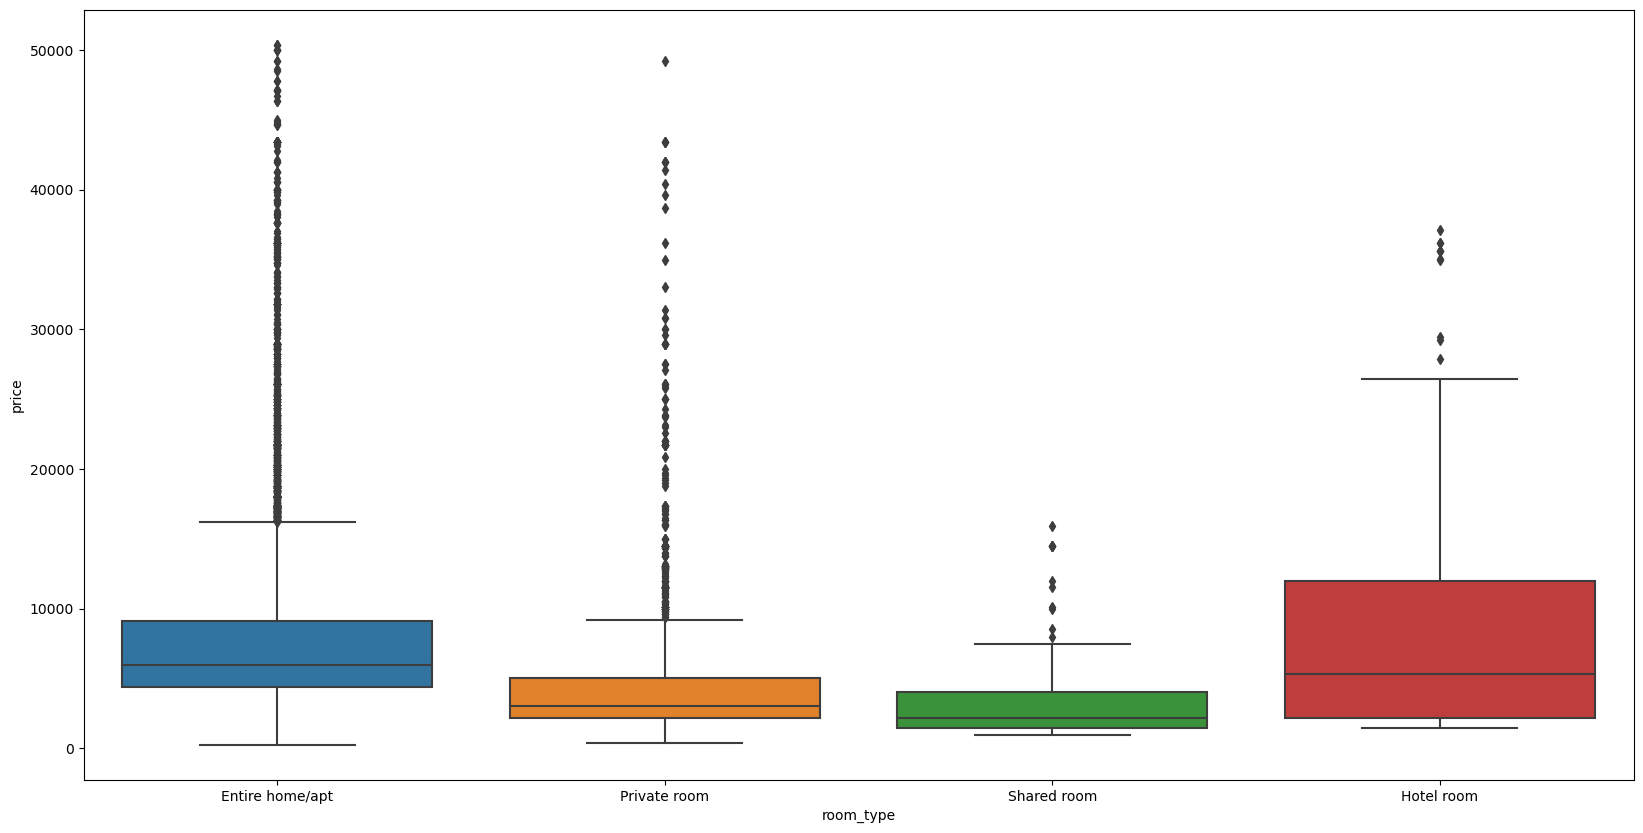

In [38]:
# I kept the values under the 99th percentile,
# so I could avoid outliers and see how the price behaves in the various categories.
q99 = df.loc[:, 'price'].quantile(0.99)
data = df[df['price'] < q99]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x='room_type', y='price', data=data)

<AxesSubplot:xlabel='room_type', ylabel='number_of_reviews'>

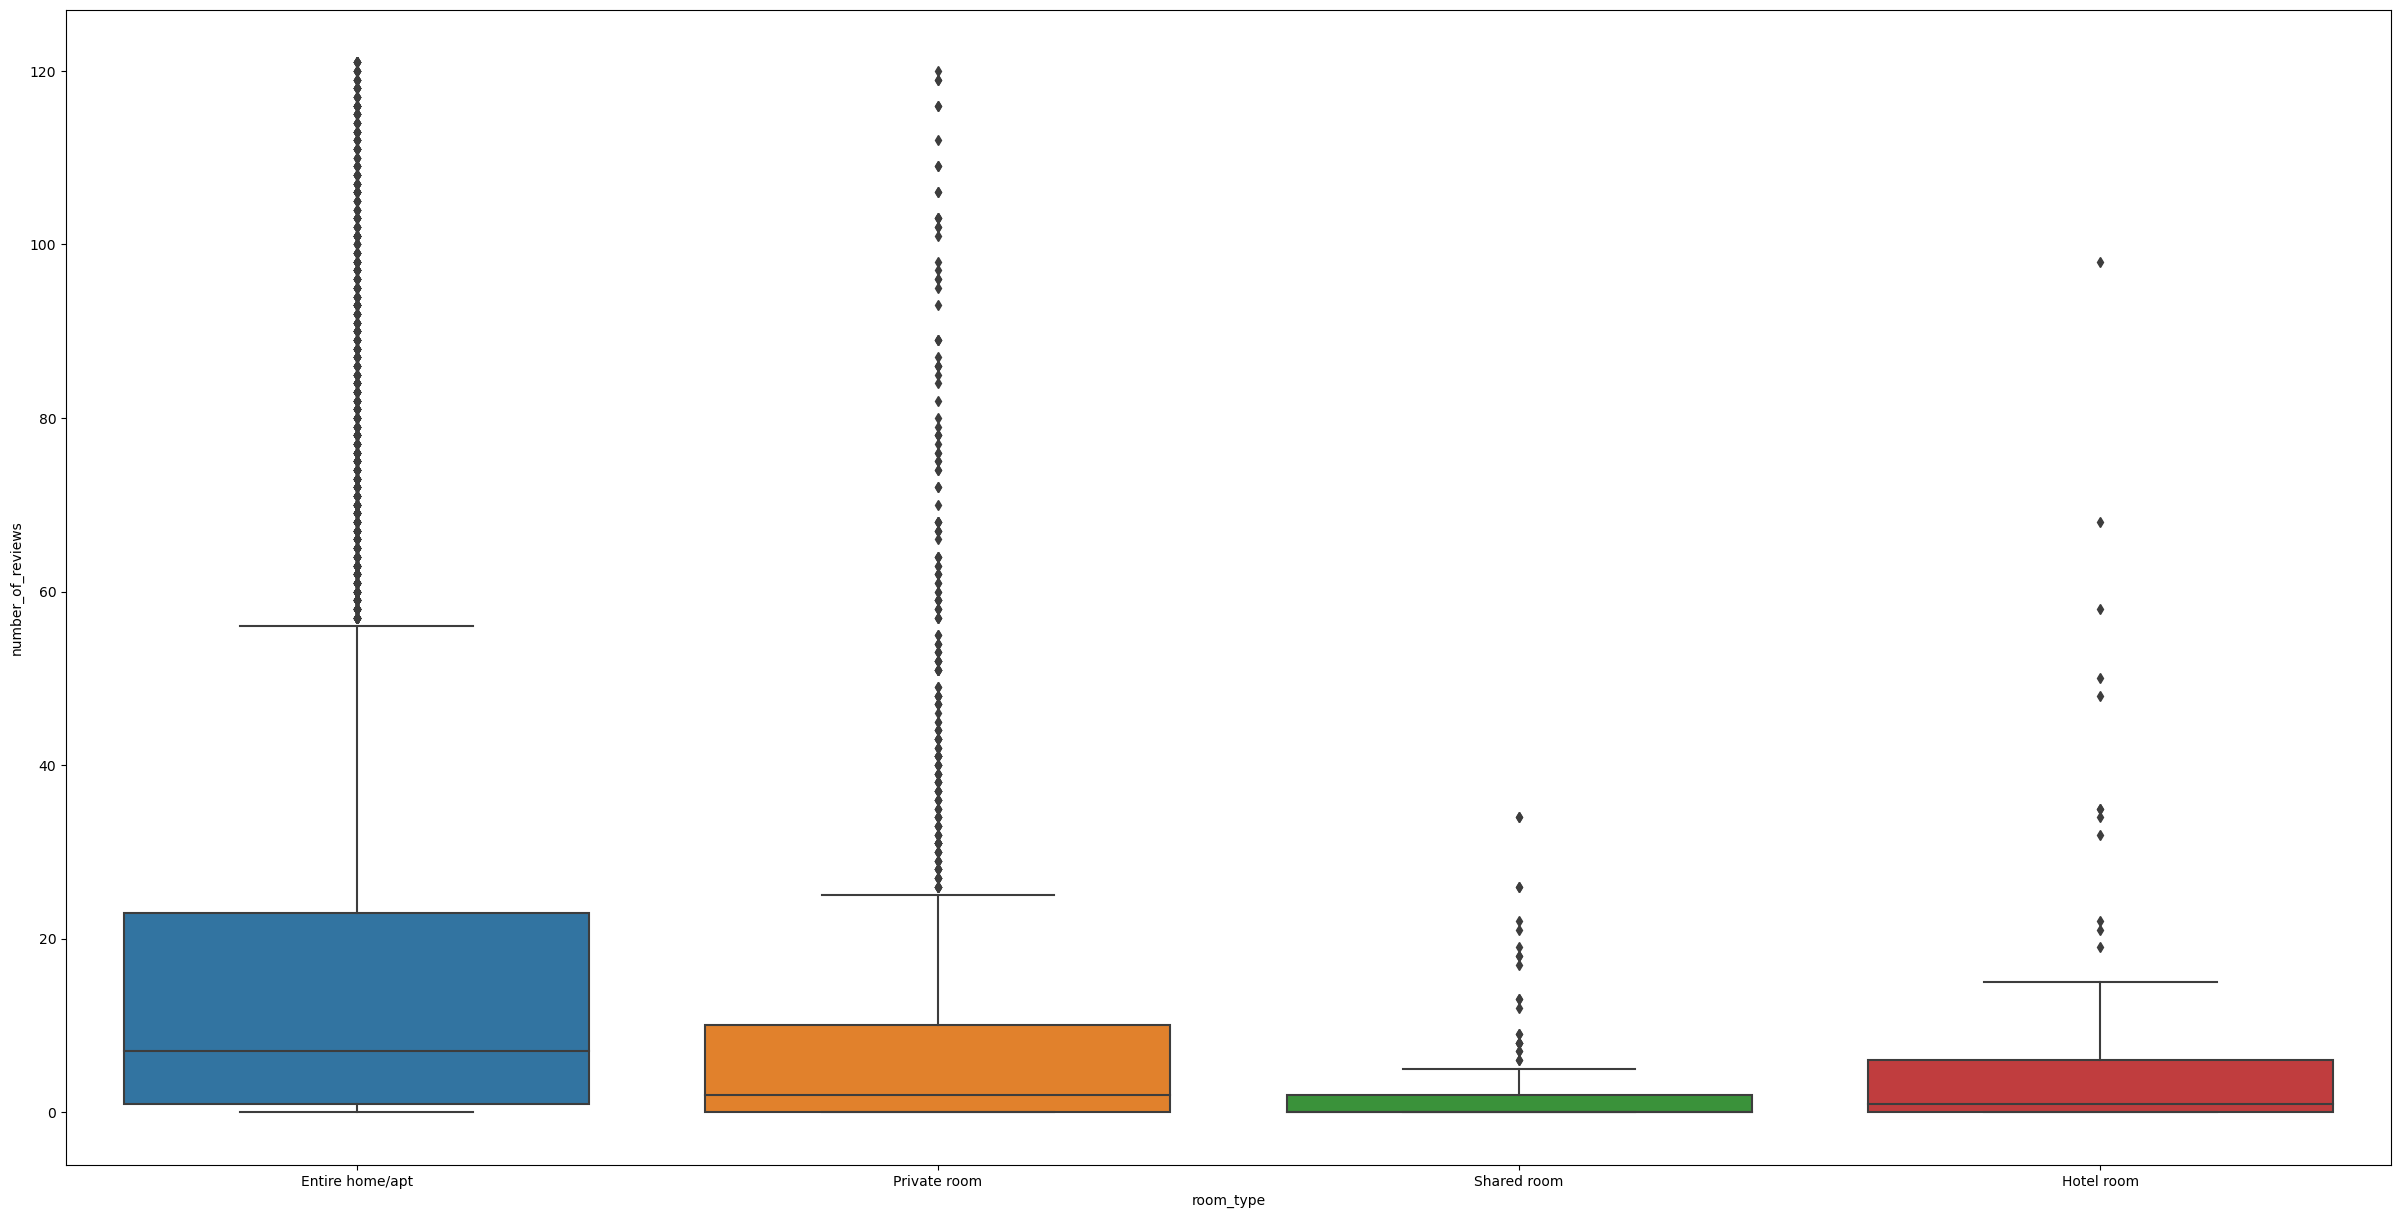

In [39]:
# Same criteria but with the 97th percentile
q97 = df.loc[:, 'number_of_reviews'].quantile(0.97)
data = df[df['number_of_reviews'] < q97]
fig, ax = plt.subplots(1, 1, figsize=(30, 15))
sns.boxplot(x='room_type', y='number_of_reviews', data=data)

## Types of listings by neighborhood

In [40]:
data = df.groupby(['neighbourhood_cleansed', 'room_type'])['id'].count()
data = pd.DataFrame(data)
data.reset_index(inplace=True)
data = pd.pivot_table(data, index='neighbourhood_cleansed', columns='room_type', values='id')
data = data.fillna(0)
data['Total'] = data['Entire home/apt'] + data['Hotel room'] + data['Private room'] + data['Shared room']
data.sort_values(by='Total', ascending=False)[:10]


room_type,Entire home/apt,Hotel room,Private room,Shared room,Total
neighbourhood_cleansed,,,,,
Palermo,5659.0,24.0,381.0,21.0,6085.0
Recoleta,2481.0,55.0,185.0,37.0,2758.0
San Nicolas,938.0,6.0,103.0,19.0,1066.0
Retiro,809.0,3.0,66.0,2.0,880.0
Belgrano,771.0,0.0,89.0,11.0,871.0
Monserrat,467.0,15.0,150.0,18.0,650.0
Almagro,513.0,1.0,126.0,4.0,644.0
Balvanera,420.0,2.0,155.0,12.0,589.0
Villa Crespo,447.0,1.0,100.0,7.0,555.0


## Neighborhood

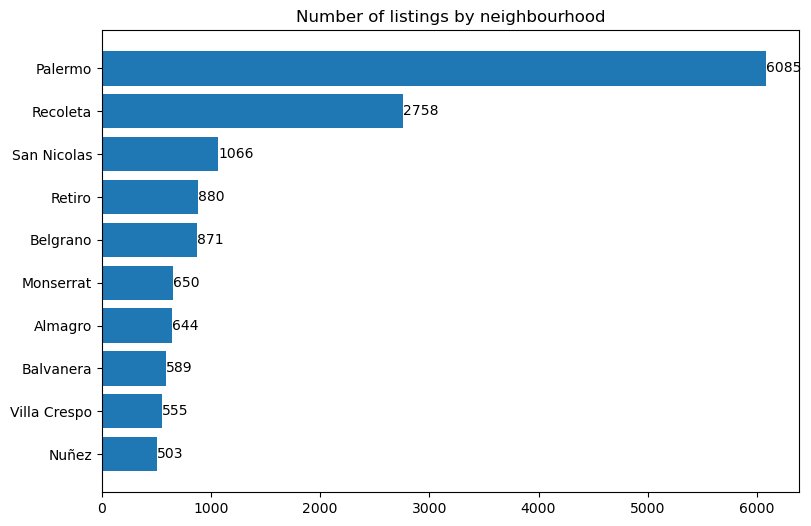

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
data = df['neighbourhood_cleansed'].value_counts().sort_values(ascending=False)[:10]
hbars = ax.barh(data.index,data.values)
plt.title('Number of listings by neighbourhood')
ax.invert_yaxis()
ax.bar_label(hbars)
plt.show()

In [42]:
neighborhoods_most_listed = ['Palermo', 'Recoleta', 'San Nicolas', 'Retiro',
                             'Belgrano', 'Monserrat', 'Almagro', 'Balvanera',
                             'Villa Crespo', 'Nuñez']
data = df[df['neighbourhood_cleansed'].isin(neighborhoods_most_listed)]
data['neighbourhood_cleansed'].unique()

array(['Palermo', 'Recoleta', 'Almagro', 'San Nicolas', 'Belgrano',
       'Nuñez', 'Monserrat', 'Balvanera', 'Villa Crespo', 'Retiro'],
      dtype=object)

Text(0.5, 1.0, 'Price distribution by neighbourhood')

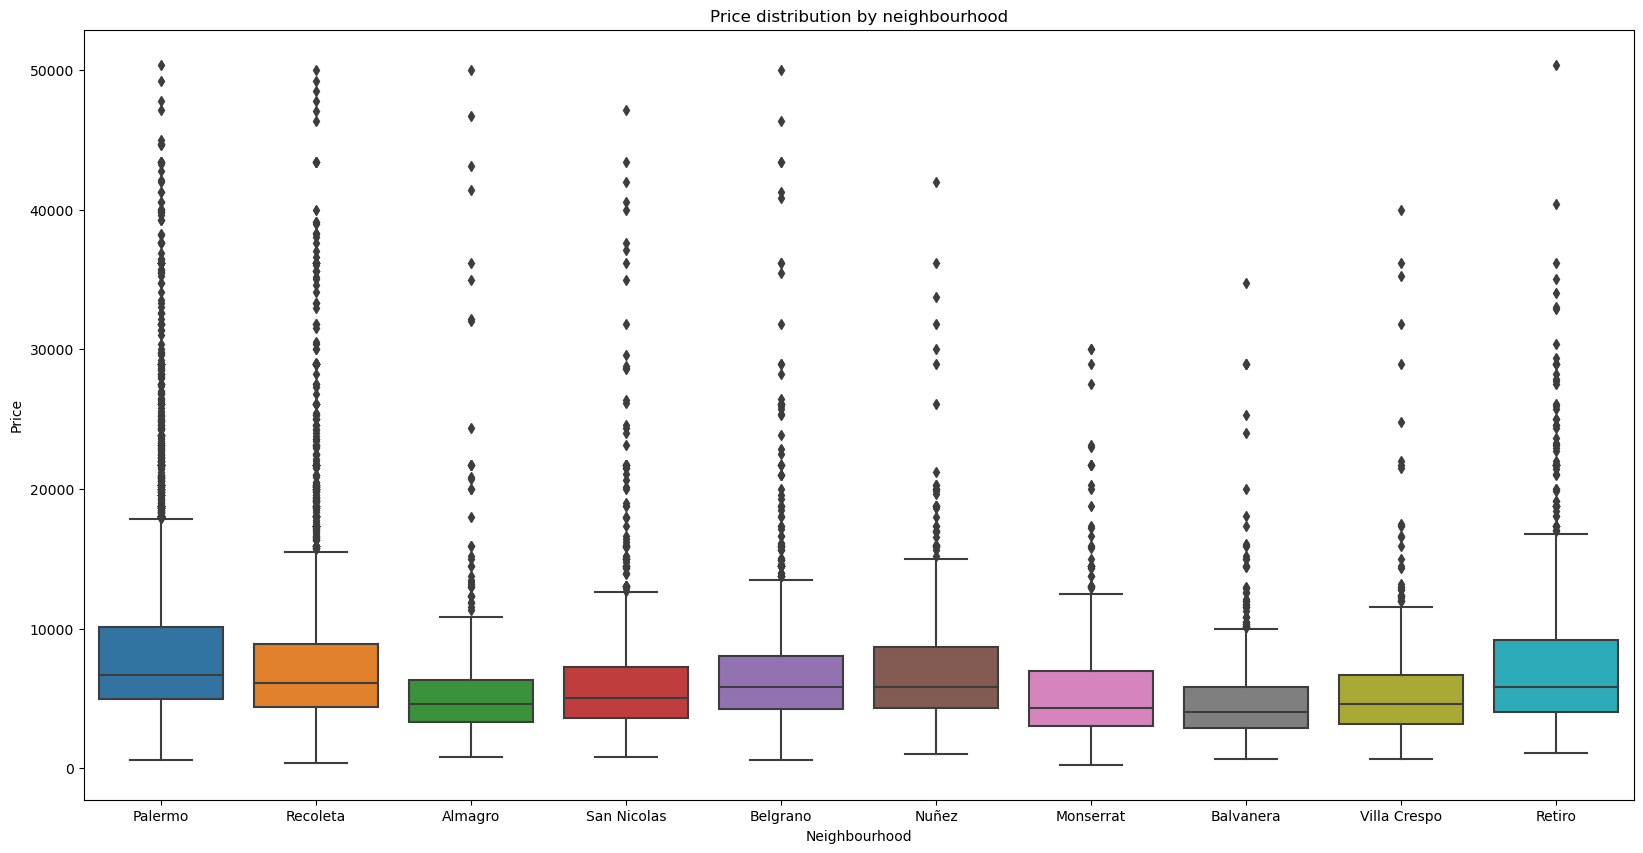

In [43]:
q99 = data.loc[:, 'price'].quantile(0.99)
data = data[data['price'] < q99]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=data)
ax.set_ylabel('Price')
ax.set_xlabel('Neighbourhood')
plt.title('Price distribution by neighbourhood')

In [44]:
print(f"The average price per night is ${round(df['price'].mean(),2)}")

The average price per night is $11307.99


In [45]:
# Average price by neighbourhood
q99 = df.loc[:, 'price'].quantile(0.99)
data = df[df['price'] < q99]
data = data.groupby(['neighbourhood_cleansed']).agg({'price': ['min', 'max', 'mean'], 'id': 'count'})
data = pd.DataFrame(data)
data.reset_index(inplace=True)
data = data.fillna(0)
data.sort_values(by=[('price','mean')], ascending=False)[:10]

neighbourhood_cleansed   price                           id
                              min      max          mean count
12                Dique 1  6800.0  49216.0  19470.666667     6
15                Dique 4  5066.0  47143.0  18211.428571     7
14                Dique 3  6928.0  28951.0  17450.666667     6
30          Puerto Madero  2000.0  48657.0  16324.168950   219
17               Floresta  1065.0  42000.0  14580.250000    28
13                Dique 2  4301.0  28951.0  14024.650000    20
47             Villa Real   963.0  43426.0  10086.625000     8
24                Palermo   600.0  50374.0   8465.889499  6009
44             Villa Luro  1440.0  35000.0   8341.466667    15
31               Recoleta   400.0  50000.0   7984.743431  2740

In [46]:
# Best reted neighbourhoods
data = pd.DataFrame(df.groupby('neighbourhood_cleansed')['review_scores_rating'].mean())
data.reset_index(inplace=True)
data.sort_values(by='review_scores_rating', ascending=False)[:10]

,neighbourhood_cleansed,review_scores_rating
21,Monte Castro,5.000000
12,Dique 1,4.950000
19,Mataderos,4.926667
44,Villa Luro,4.923636
27,Parque Chas,4.897895
0,Agronomia,4.888667
38,Versalles,4.880000
45,Villa Ortuzar,4.879091
42,Villa Gral. Mitre,4.872000
49,Villa Santa Rita,4.869474


In [47]:
data = df.groupby(['neighbourhood_cleansed']).agg({'price': 'mean', 'review_scores_rating': 'mean'})
data = pd.DataFrame(data)
data.reset_index(inplace=True)
data = data.fillna(0)
data['price/rating'] = round(data['price'] / data['review_scores_rating'],0)
data = data.sort_values(by=['price/rating'])[:10]

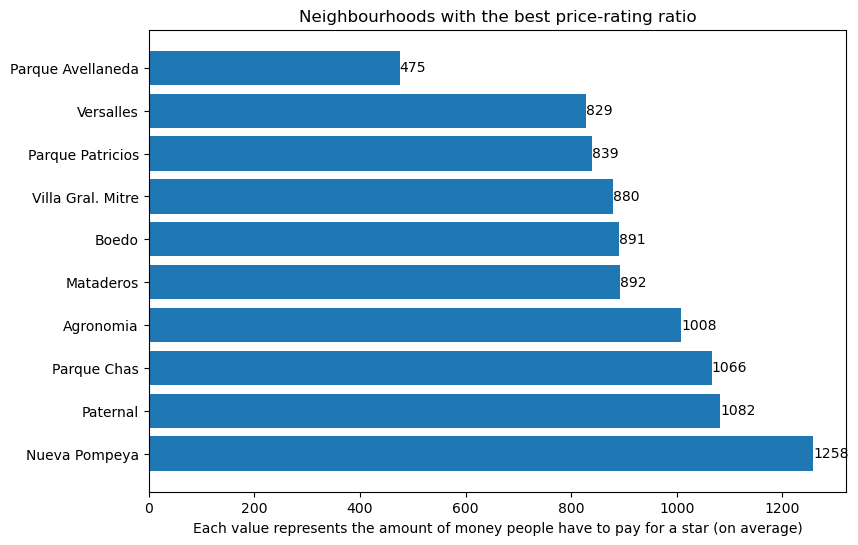

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
hbars = ax.barh(data['neighbourhood_cleansed'],data['price/rating'])
plt.title('Neighbourhoods with the best price-rating ratio')
ax.set_xlabel('Each value represents the amount of money people have to pay for a star (on average)')
ax.invert_yaxis()
ax.bar_label(hbars)
plt.show()

## Amenities Analysis

In [49]:
df['amenities'][0]

'["Shared fenced garden or backyard", "Elevator", "Drying rack for clothing", "Wine glasses", "Host greets you", "Refrigerator", "Shared hot tub - open specific hours", "Heating", "Dining table", "Private entrance", "Essentials", "Single level home", "Bidet", "Hangers", "Oven", "Cleaning products", "Outdoor furniture", "Freezer", "Microwave", "Cable TV", "Body soap", "Air conditioning", "Hot water", "Extra pillows and blankets", "TV with standard cable", "Wifi", "Dishes and silverware", "Shared sauna", "Toaster", "Gym", "Stove", "Paid street parking off premises", "Shared pool", "Long term stays allowed", "Iron", "Kitchen", "Paid washer \\u2013 In building", "Laundromat nearby", "Bathtub", "Room-darkening shades", "Hair dryer", "Bed linens", "Safe", "Coffee maker", "Cooking basics", "Private patio or balcony", "Clothing storage: dresser and closet", "Paid dryer \\u2013 In building"]'

In [50]:
# Cleaning the df column
corpus = list(df['amenities'].str.replace('[','').str.replace(']','').str.replace('"','').str.split(','))
corpus[:2]

[['Shared fenced garden or backyard',
  ' Elevator',
  ' Drying rack for clothing',
  ' Wine glasses',
  ' Host greets you',
  ' Refrigerator',
  ' Shared hot tub - open specific hours',
  ' Heating',
  ' Dining table',
  ' Private entrance',
  ' Essentials',
  ' Single level home',
  ' Bidet',
  ' Hangers',
  ' Oven',
  ' Cleaning products',
  ' Outdoor furniture',
  ' Freezer',
  ' Microwave',
  ' Cable TV',
  ' Body soap',
  ' Air conditioning',
  ' Hot water',
  ' Extra pillows and blankets',
  ' TV with standard cable',
  ' Wifi',
  ' Dishes and silverware',
  ' Shared sauna',
  ' Toaster',
  ' Gym',
  ' Stove',
  ' Paid street parking off premises',
  ' Shared pool',
  ' Long term stays allowed',
  ' Iron',
  ' Kitchen',
  ' Paid washer \\u2013 In building',
  ' Laundromat nearby',
  ' Bathtub',
  ' Room-darkening shades',
  ' Hair dryer',
  ' Bed linens',
  ' Safe',
  ' Coffee maker',
  ' Cooking basics',
  ' Private patio or balcony',
  ' Clothing storage: dresser and closet',


In [51]:
#Unzip list of list
corpus_merged = list(chain(*corpus))
corpus_merged[:20]

['Shared fenced garden or backyard',
 ' Elevator',
 ' Drying rack for clothing',
 ' Wine glasses',
 ' Host greets you',
 ' Refrigerator',
 ' Shared hot tub - open specific hours',
 ' Heating',
 ' Dining table',
 ' Private entrance',
 ' Essentials',
 ' Single level home',
 ' Bidet',
 ' Hangers',
 ' Oven',
 ' Cleaning products',
 ' Outdoor furniture',
 ' Freezer',
 ' Microwave',
 ' Cable TV']

In [52]:
#Counting the appearance of each amenity
list_amenities = [word.strip() for word in corpus_merged]
counts_amenities = Counter(list_amenities)
counts_amenities

Counter({'Shared fenced garden or backyard': 265,
         'Elevator': 11151,
         'Drying rack for clothing': 3246,
         'Wine glasses': 4373,
         'Host greets you': 5042,
         'Refrigerator': 11873,
         'Shared hot tub - open specific hours': 3,
         'Heating': 12488,
         'Dining table': 5029,
         'Private entrance': 4222,
         'Essentials': 15518,
         'Single level home': 2296,
         'Bidet': 6378,
         'Hangers': 14286,
         'Oven': 7933,
         'Cleaning products': 5287,
         'Outdoor furniture': 2660,
         'Freezer': 4645,
         'Microwave': 9826,
         'Cable TV': 5939,
         'Body soap': 3912,
         'Air conditioning': 11638,
         'Hot water': 13315,
         'Extra pillows and blankets': 7745,
         'TV with standard cable': 4044,
         'Wifi': 16540,
         'Dishes and silverware': 13163,
         'Shared sauna': 377,
         'Toaster': 4677,
         'Gym': 1553,
         'Stove': 6329

In [53]:
# Dictionary to df
df_amenities = pd.DataFrame(counts_amenities.items(), columns=['Amenities', 'Total']).sort_values(by='Total', ascending=False).reset_index(drop=True)
df_amenities['% of listings'] = round((df_amenities['Total']/len(df))*100,2)
df_amenities[:20]

,Amenities,Total,% of listings
0,Kitchen,17016,94.81
1,Long term stays allowed,16639,92.71
2,Wifi,16540,92.16
3,Essentials,15518,86.47
4,Hangers,14286,79.60
5,Hot water,13315,74.19
6,Dishes and silverware,13163,73.34
7,Heating,12488,69.58
8,Cooking basics,12418,69.19
9,Refrigerator,11873,66.16


# Conclusions

- The number of hosts grew linearly and steadily over the 2010-2022 period. By the time the dataset was created, there were 10127 hosts with listings.
- There is one host with 2365 listings. Lives in the UK.
- 93% of the hosts are located in Argentina and 83% of them are in Buenos Aires. Of the remaining 7% who live outside of Argentina, the cities with the highest participation are Barcelona, Madrid, Miami, and New York, among others.
- 74% of the hosts are super-hosts.
- There is no evidence of a significant difference between the prices offered by the super hosts that the standard ones.
- Super hosts receive, on average, a better overall review score than standard hosts.
- 79% of the hosts have only one listing.
- Of the listing types, 87% correspond to the entire home/apartment, followed by a private room with 11%.
- The neighborhoods with more listings are Palermo, Recoleta and San Nicolás.
- It can be seen that both Palermo, Recoleta, Nuñez, and Retiro have a higher price than the other 10 neighborhoods with the most listings, although with a greater dispersion (greater interquartile range). In all cases, I observe many outliers.
- The average price for one night is $11308. The most expensive neighborhoods are Dock 1, Dock 4, Dock 3 and Puerto Madero. For this analysis, I kept the values under the 99th percentile.
- The neighborhoods with the best price-rating ratio are Parque Avellaneda, Versalles, Parque Patricios, Villa General Mitre and Boedo.
